# LBP (with Noise based Confidence Calculation)
Besides the transformation to illumination invariant representation (invariant to monotonic intensity shifts), a confidence measure is proposed to distinguish between homogeneous areas that tend to preduse noisy lbp output and non-homogeneous areas. In the calculation the uncertainty of the sensor values is taken into account. Then the noise is propagated through the transform, leading to expected noise defined by a covariance matrix. Then the Mahalanobis distance is calculated, that provides a distance measure for every pixel, of belonging to homogeneous areas. Based on the distance the probability is calculated that the pixel is non-homogenous.

In [1]:
#dependencies
import numpy as np
import os, sys
import math
from scipy import signal, stats

## Noise Model Input Image
Additive zero-centered Gaussian Noise $\eta \sim \mathcal{N}(0,\sigma^2)$ is assumed, such that each observed pixel (intensity) $\hat{I}$, is approximated by $\hat{I}= I+\eta$, such that $$\hat{I}\sim \mathcal{N}(I,\sigma^2)$$, with I beeing the true intensity value

## LBP(radius $r$, points $p$)
A set of $N$ neighbors $n_0..n_N$ is determined based on $r$ and $p$.  Each neighbor is compared to the center pixel $c$: In a predefined order along the circle of neighbors, a binary number $b$ is generated, where 0 denotes an intensity lower than the center pixel($d_{ic} = n_i-c$,$d_{ic}<0 \Rightarrow b_i = 0$) and 1 otherwise. Converting this binary number to a decimal number gives the center pixels LBP value.\\

### Derivation of Noise Propagation 
The vector $\hat{d}_c = \hat{d}_{0c}...\hat{d}_{Nc}$, is the vector of differences, with 
$\hat{d}_{ic} = \hat{n}_i-\hat{c}$

The variance and covariance of the differences $d_{ic}$ is determined to achive a covariance matric.

In [2]:
## Determine covariance matrix of d_i,j by monte carlo simulation
size = 1000000
for sigma in [1,2,4,10]: 

    n1 = np.random.normal(loc= np.random.uniform(0,255), scale=sigma, size=size)
    n2 = np.random.normal(loc= np.random.uniform(0,255), scale=sigma, size=size)
    n3 = np.random.normal(loc= np.random.uniform(0,255), scale=sigma, size=size)
    c = np.random.normal(loc= np.random.uniform(0,255), scale=sigma, size=size)

    print("sigma: %.2f, variance: %.2f"%(np.sqrt(np.var(n1)), np.var(n1)))
    dc1 = n1-c
    dc2 = n2-c
    dc3 = n3-c
    print("Covariance matrix:",np.cov([dc1,dc2,dc3], rowvar=True))

sigma: 1.00, variance: 1.00
Covariance matrix: [[2.00059885 1.00016436 1.00097367]
 [1.00016436 1.99710969 0.9980351 ]
 [1.00097367 0.9980351  2.00008699]]
sigma: 2.00, variance: 3.99
Covariance matrix: [[7.9804967  3.99657434 3.98648322]
 [3.99657434 7.98627537 3.98964748]
 [3.98648322 3.98964748 7.98739332]]
sigma: 4.00, variance: 15.97
Covariance matrix: [[31.96366496 15.97232253 16.02435721]
 [15.97232253 31.98665996 16.00266066]
 [16.02435721 16.00266066 32.02728504]]
sigma: 9.99, variance: 99.76
Covariance matrix: [[199.84673867  99.92895086 100.07281948]
 [ 99.92895086 199.76889782 100.13865821]
 [100.07281948 100.13865821 200.15249701]]


From the output, we can deduce:
$$\hat{d}_c\sim \mathcal{N}\left(\left(\begin{array}{c}
	d_{0c} =n_0-c\\
	d_{1c} =n_1-c\\
	...\\
	d_{Nc} =n_N-c\\
	\end{array}\right), \Sigma_c = \left(\begin{array}{cccc}
	2\sigma^2&	\sigma^2&...&\sigma^2\\
	\sigma^2&	2\sigma^2&...&\sigma^2\\
	...&...&...&...\\
	\sigma^2&\sigma^2&...&2\sigma^2\\
	\end{array}\right),\right)$$

# Apply LBP on some testimages

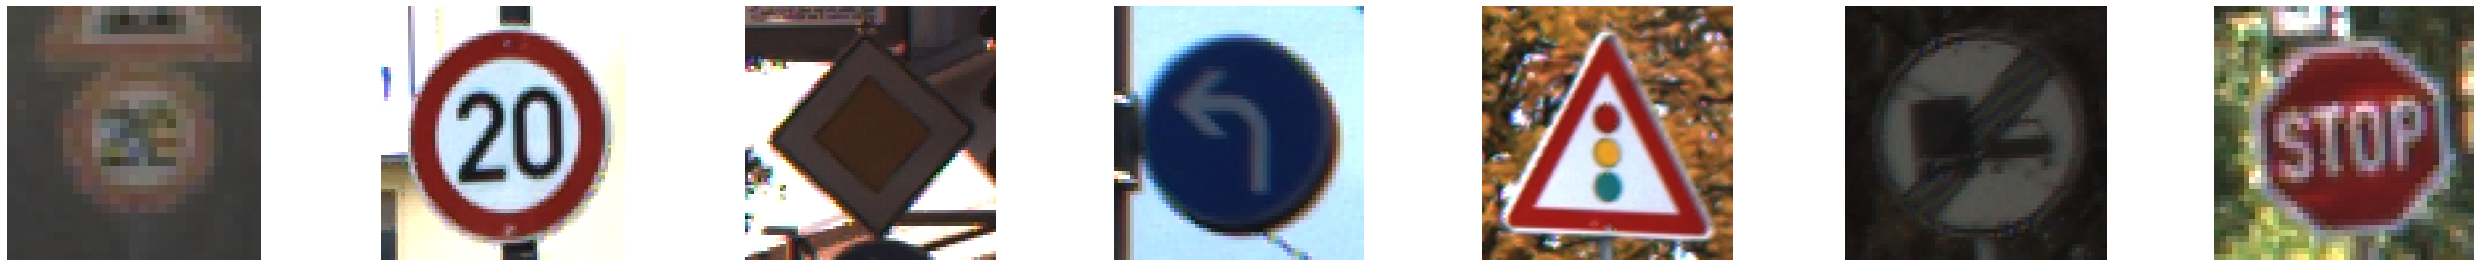

In [ ]:
#Load and plot input  images
from utils_image_load_plot import load_GTSRB_test_images, plot_images, plot_hists, plot_distributions
#TODO!: update path to GTSRB dataset:
images = load_GTSRB_test_images(path = "TODO") 
plot_images(images)

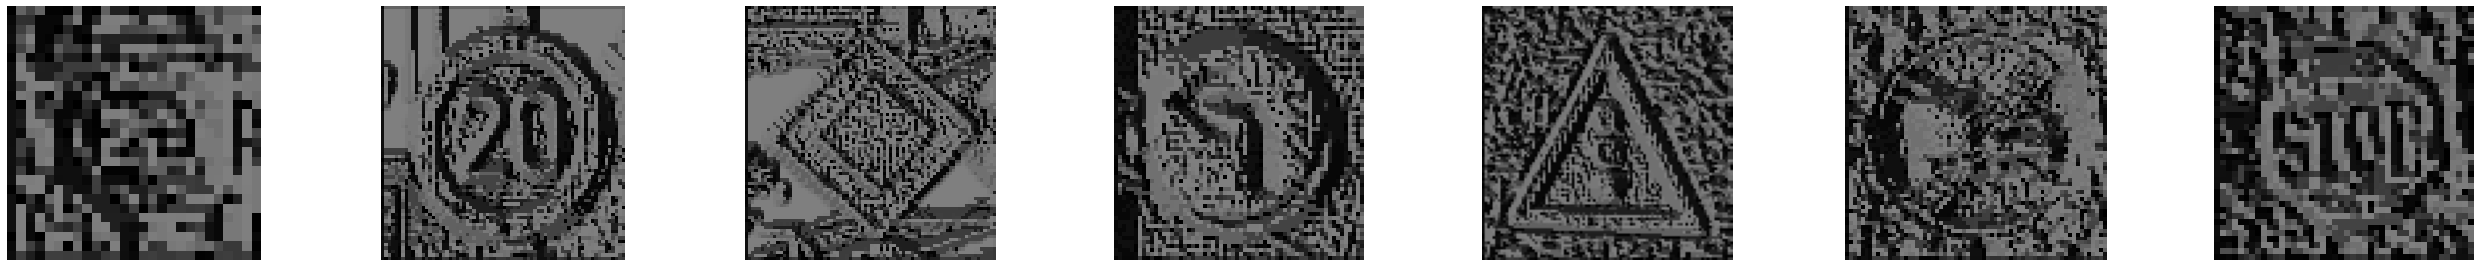

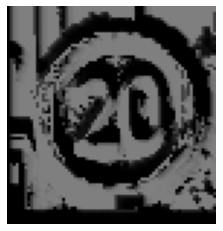

In [4]:
import matplotlib.pyplot as plt
class Intensity():
    def __call__(self, x):
        return x.sum(axis =2)//3

def diffs(radius, num_points, data):
    neigbour = np.zeros((data.shape[0],data.shape[1],num_points))
    max_x, max_y = data.shape[1], data.shape[0]
    angle = 2 * math.pi / num_points
    positions=[(int(round(radius * math.cos(angle * i))),
                 int(round(radius * math.sin(angle * i))))
                 for i in range(num_points)]
    
    for i, (y,x) in enumerate(positions):
        neigbour[max(0,-y):min(max_y, max_y-y), 
                 max(0,-x):min(max_x, max_x-x),
                 i] = data[max(0,y):min(max_y, max_y+y),
                           max(0,x):min(max_x, max_x+x)]
    return neigbour - np.repeat(data[:, :, np.newaxis], num_points, axis=2) #height,width, num_points
    
def lbp_transform(radius, num_points, data):
    diff = diffs(radius, num_points, data)

    # convert to binary: 0 if lessequall
    diff[diff >= 0] = 1
    diff[diff < 0] = 0

    # convert to decimal
    for i in range(num_points):
        diff[:,:,i]= diff[:,:,i]*2**i
    d = np.sum(diff,axis=2)
    out = d/float(2**(num_points+1)-1)#max decimal number, defined by number of points
    return out

intensity_transform = Intensity()
plot_images([lbp_transform(1,8,intensity_transform(img)) for img in images])
plt.axis('off')
img =lbp_transform(5,40,intensity_transform(images[1]))
plt.imshow(img, cmap="gray",vmin = 0, vmax = 1)

## Noise Estimation
Based on:
Shen-Chuan Tai and Shih-Ming Yang, "A fast method for image noise estimation using Laplacian operator and adaptive edge detection," 2008 3rd International Symposium on Communications, Control and Signal Processing, Saint Julian's, Malta, 2008, pp. 1077-1081, doi: 10.1109/ISCCSP.2008.4537384.

with the addition that areas with very strong or very weak saturation or intensity are not used.

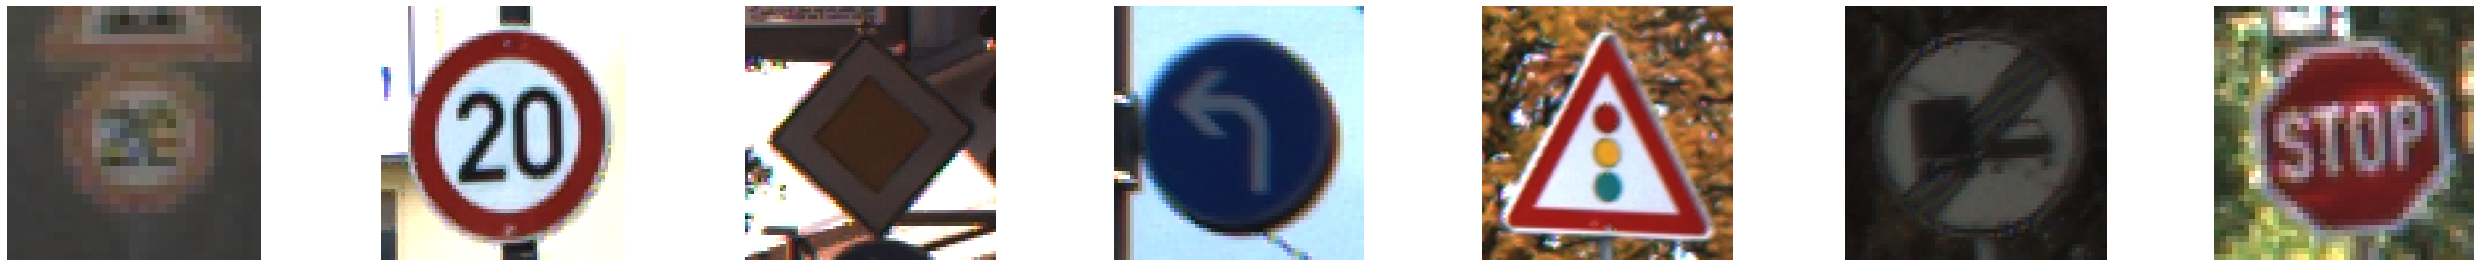

image 0 estimated noise(sigmas):0.92
image 1 estimated noise(sigmas):0.93
image 2 estimated noise(sigmas):0.78
image 3 estimated noise(sigmas):0.72
image 4 estimated noise(sigmas):1.24
image 5 estimated noise(sigmas):1.11
image 6 estimated noise(sigmas):1.50


In [5]:
# returns a mask, for all pixels, 
# if it belongs to p % of the positions with least of the edges
def homogeneous_regions(img,  intensity = None, saturation = None, p = 0.1):
    sobel1 = [[-1,-2, -1],
          [ 0, 0, 0],
          [ 1, 2, 1]]
    sobel2 = [[-1, 0, 1],
          [-2, 0, 2],
          [-1, 0, 1]]

    # gradient calculation with sobel filters
    g1 = signal.convolve2d(img, sobel1, mode = 'same')
    g2 = signal.convolve2d(img, sobel2, mode = 'same')
    g = np.absolute(g1) + np.absolute(g2)
    #cutoff (don't use them for calculation) extreme areas
    if ((intensity is not None)
        and (np.count_nonzero(intensity > 0.95*255) < 0.5*img.shape[0]*img.shape[1])
        and (np.count_nonzero(intensity < 0.05*255) < 0.5*img.shape[0]*img.shape[1])):
        #dont use positions with high and low intensity I>0.05*255 and I< 0.95*255*3
        g[intensity > 0.95*255] = g.max()
        g[intensity < 0.05*255] = g.max()
    if saturation is not None:
        #dont use positions with high and low sturation S>0.05 and S< 0.95
        g[saturation > 0.95] = g.max()
        g[saturation < 0.05] = g.max()
    threshhold_g = g.min() # threshhold = the G value when the accumulated histogram reaches p% of the whole image
    if (not (g.max() == g.min())):
        # compute the histogram of G # TODO check if could be replaced by sort
        hist_g = np.histogram(g, bins = int(g.max()-g.min()), range = (g.min(),g.max()))
        # calculate threshhold
        p_pixels =  p * img.shape[0] * img.shape[1]
        sum_pixels = 0
        for gi, g_value in enumerate(hist_g[0]):
            sum_pixels += g_value
            if sum_pixels > p_pixels:
                threshhold_g = g.min()+gi
                break
    masked_img = np.ma.masked_where(g > threshhold_g, img)
    return masked_img

def estimateGaussianNoise(img, intensity=None, saturation=None):
    laplacian = [[1, -2, 1],#LaPlacioan Operator
        [-2, 4, -2],
        [1, -2, 1]]
    img_suppressed_structures = signal.convolve2d(img, laplacian, mode='valid')

    intensity = None if intensity is None else intensity[1:-1,1:-1] #pixels lost by convolution
    saturation = None if saturation is None else saturation[1:-1,1:-1] #pixels lost by convolution
    edge_mask = homogeneous_regions(img[1:-1,1:-1], intensity, saturation).mask

    abs_residuals = np.ma.array(np.absolute(img_suppressed_structures), mask = edge_mask)
    summed_abs_residuals = np.sum(np.ma.sum(abs_residuals))
    N = (abs_residuals.shape[0]*abs_residuals.shape[1]) - np.count_nonzero(edge_mask)
    return summed_abs_residuals * np.sqrt(0.5 * np.pi) / (6 * N)

plot_images(images)
for i,img in enumerate(images):
    sigma = estimateGaussianNoise(intensity_transform(img), Intensity()(img))
    print("image %i estimated noise(sigmas):%.2f"%(i,sigma))
    

# Noise Propagation

In [6]:
def noise_prop(num_points,sigma):
    #Calculate covariance matrix S
    S = np.full((num_points,num_points), sigma**2) #points gives dimenion of binary number
    np.fill_diagonal(S,2*sigma**2)
    return S

#Example calculation image 0
print("image 0:")
sigma = estimateGaussianNoise(intensity_transform(images[0]), Intensity()(images[0]))
print("estimated sigma: %.2f"%(sigma))
cov_matrix = noise_prop(8,sigma)
print("estimated VAR(point1): %.2f"%(cov_matrix[0,0]))
print("estimated COV(point1, point2): %.2f"%(cov_matrix[0,1]))

image 0:
estimated sigma: 0.92
estimated VAR(point1): 1.68
estimated COV(point1, point2): 0.84


## Calculate Confidence of LBP
Areas with no texture are approximated as areas where the differences are very small (dependend on the variance). 

The Mahalanobis distance between areas with no texture($\mu =(0...0)^T,\Sigma = \Sigma_c)$ is calculated, based on the distance the probability is calculated.
		$$md^2 = \left(\hat{d}_c-(0...0)^T\right)^T\Sigma_c^{-1}\left(\hat{d}_c-(0...0)^T\right) \text{  (Mahalanobis distance)}$$
        
with $\Sigma_c^{-1} = \left(\begin{array}{cccc}
		 \frac{d}{(d+1)\sigma^2}&	-\frac{1}{(d+1)\sigma^2}&...&-\frac{1}{(d+1)\sigma^2}\\
		 -\frac{1}{(d+1)\sigma^2}&	\frac{d}{(d+1)\sigma^2}&...&-\frac{1}{(d+1)\sigma^2}\\
		 ...&...&...&...\\
		 -\frac{1}{(d+1)\sigma^2}&-\frac{1}{(d+1)\sigma^2}&...&\frac{d}{(d+1)\sigma^2}\\ 
		 \end{array}\right)$, with dimension d of $\Sigma$
       
\begin{align}
    Conf(LBP) &= P(\textit{"no texture"}|md^2)\\
    &= \frac{P(md^2|\textit{"no texture"})P(\textit{"no texture"})}{P(md^2)}
\end{align}


1. Mahalanobis Distance is calculates
2. H0(no texture) and H1(texture) are approximated by mixture of noncentral chi square distributions
3. Based on the model a probability is calculated
![pipelineimage](conf_pipeline.png)

### Mahalanobis Distance Calculation

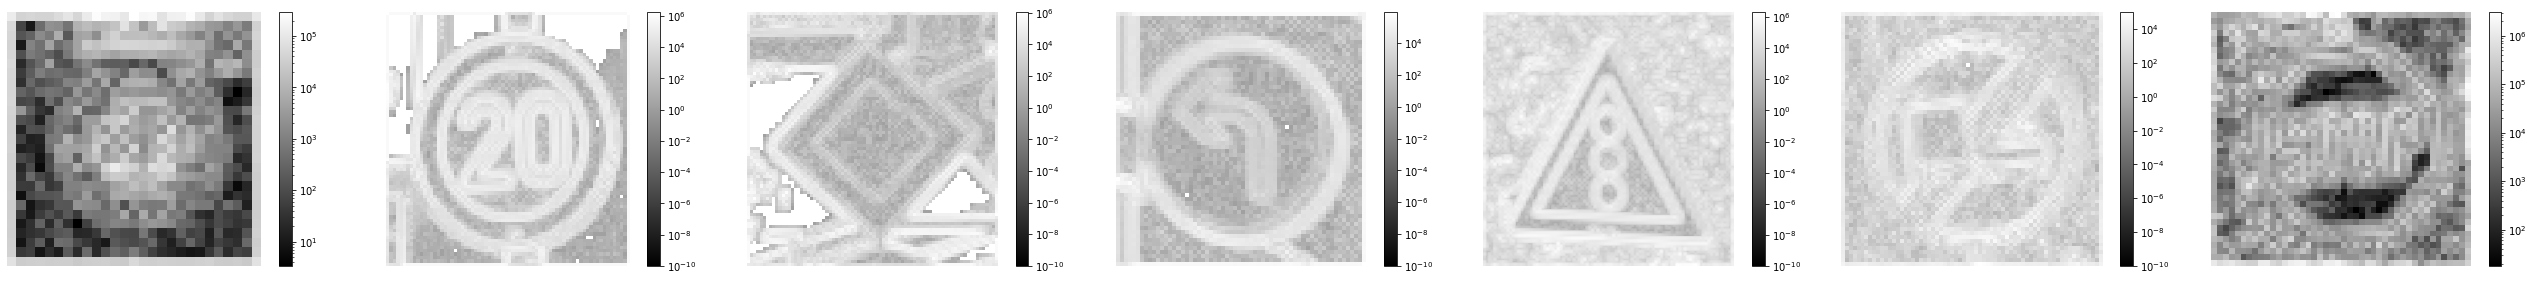

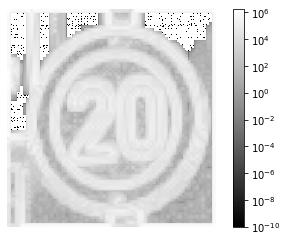

In [13]:
#calculate andvizualize mah distance 
def mahalanobis_distance(diffs, inv_S, num_points):
    mean = np.zeros((num_points,1)) #distance to zero centered
    mah = np.zeros((diffs.shape[0], diffs.shape[1]))
    for i in range(diffs.shape[0]): #TODO optimization possible?
        for j in range(diffs.shape[1]):
            point = diffs[i,j].reshape(num_points,1)
            mah[i,j] = np.matmul(np.matmul(np.transpose(point-mean),inv_S),(point-mean))
    return mah      

mah_distances = []
r, p = 1, 8
for img in images:
    sigma = estimateGaussianNoise(intensity_transform(img),Intensity()(img))
    mah_distances.append(mahalanobis_distance(diffs(r,p,intensity_transform(img)), noise_prop(p,sigma),p))
plot_images(mah_distances,own_scale = True, lognorm= True, colorbar = True)
plt.axis('off')
import matplotlib.colors as colors
eps = 1e-10
img = mah_distances[1]
norm = colors.LogNorm(vmin=max(eps,img.min()), vmax=img.max())
im = plt.imshow(img, cmap="gray", norm=norm)
plt.colorbar(im)


means:  12178.85,       54673.04,       22235.35,       20331.48,       46838.25,       2150.47,       100544.65,       
median:  1529.67,       3915.32,       338.61,       297.24,       12223.44,       467.14,       38139.54,       
max:  286922.51,       1685679.58,       1057449.66,       856460.45,       2000168.44,       97658.62,       3038430.59,       


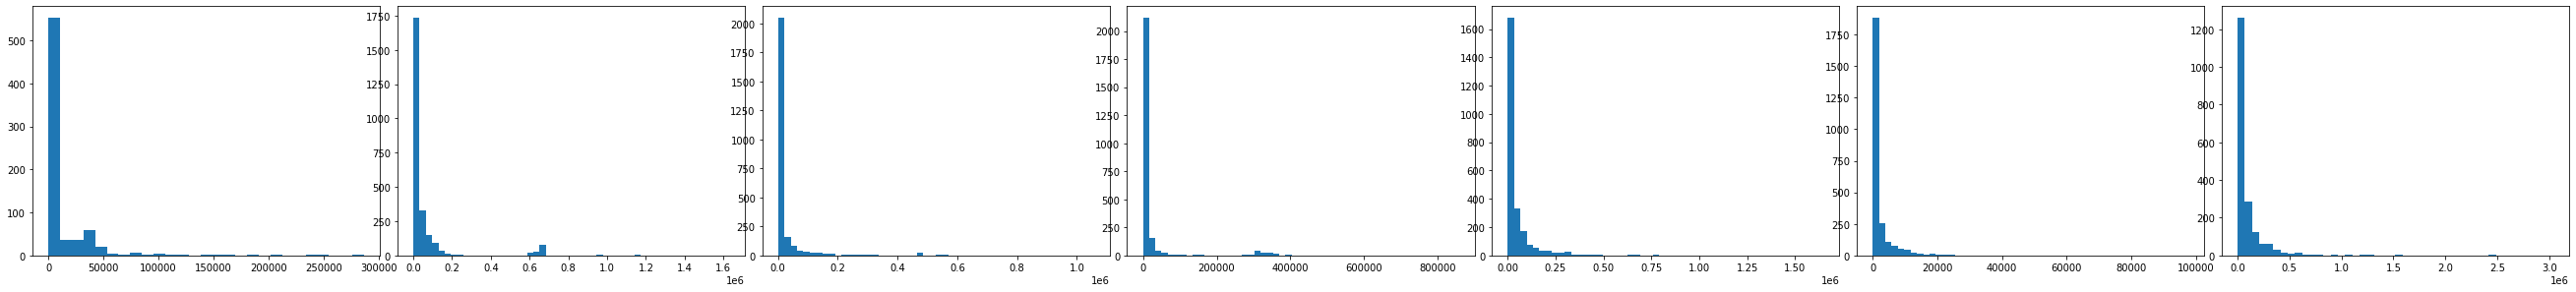

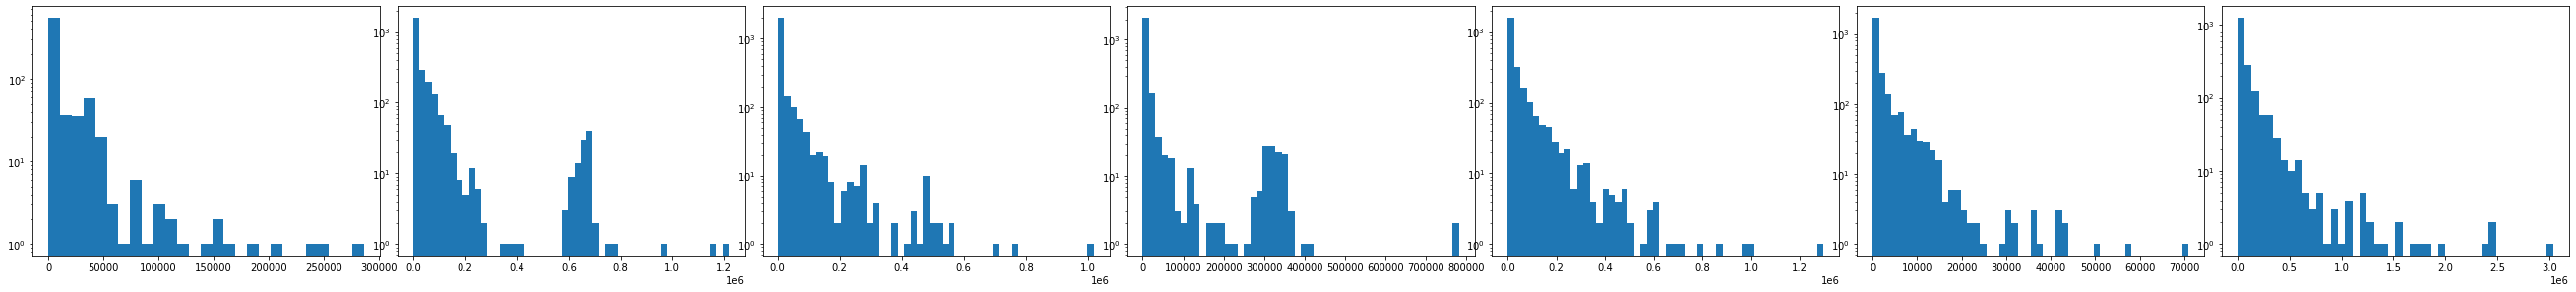

Text(0.5, 0, 'squared Mahalanobis distance')

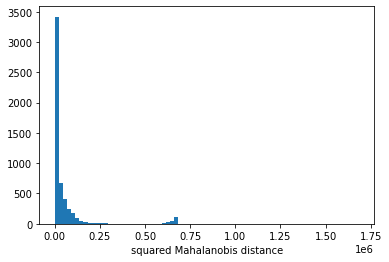

In [14]:
#plot some stats
def print_float_list(values, name):
    print(name, end =":  ")
    l =["%0.2f"%(i) for i in values]
    for i in range(len(l)):
        print(l[i], end =",       ") 
    print("")
    
print_float_list([np.mean(mah) for mah in mah_distances], "means")
print_float_list([np.median(mah) for mah in mah_distances], "median")
print_float_list([np.max(mah) for mah in mah_distances], "max")

#hists
plot_hists([np.reshape(mah, (-1)) for mah in mah_distances])
plot_hists([np.sort(np.reshape(mah, (-1))) for mah in mah_distances], log = True)
plt.hist(np.reshape(mah_distances[1], (-1)), bins='sqrt')
plt.xlabel('squared Mahalanobis distance')

### Bayesian Hypothes Test if in uncertain(homogeneous) area
We try out different models (defined by the seperating lambda value) to see which models the homogeneous areas best

lambda: 0


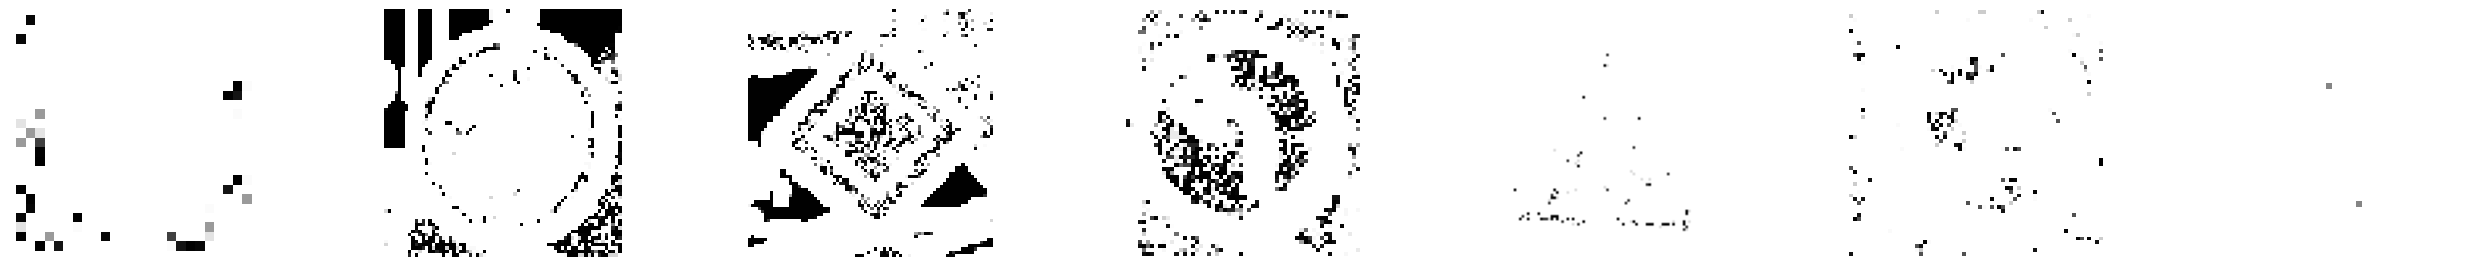

lambda: 1


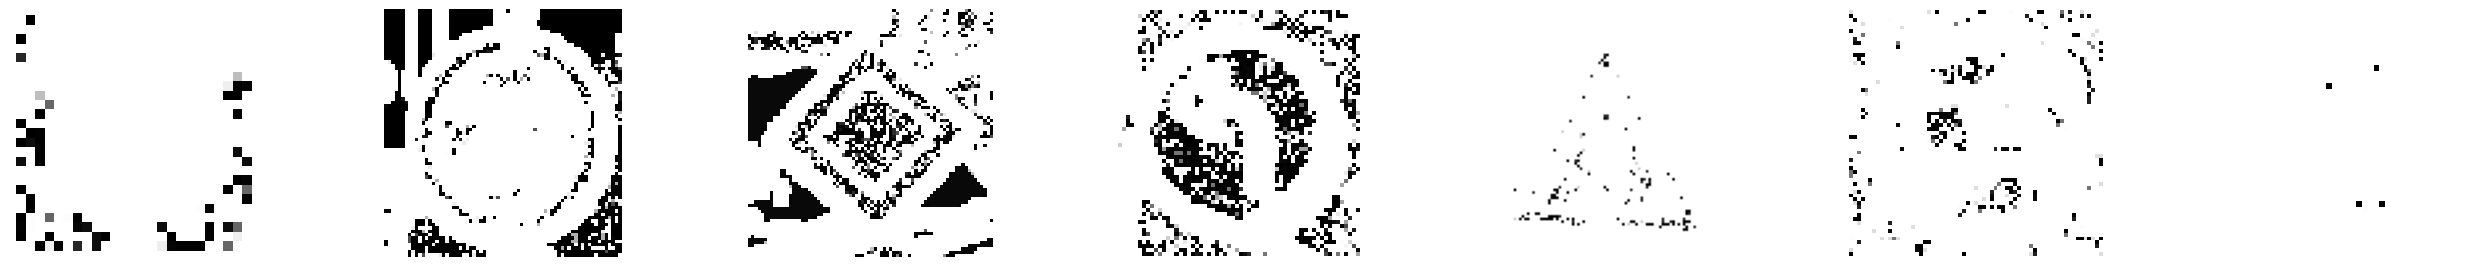

lambda: 10


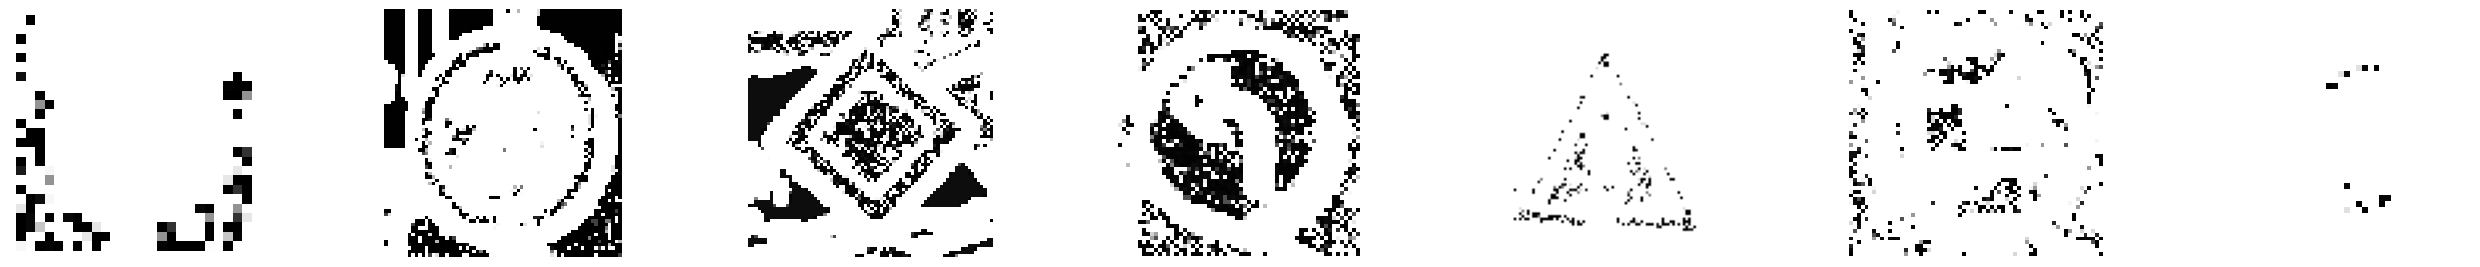

lambda: 100


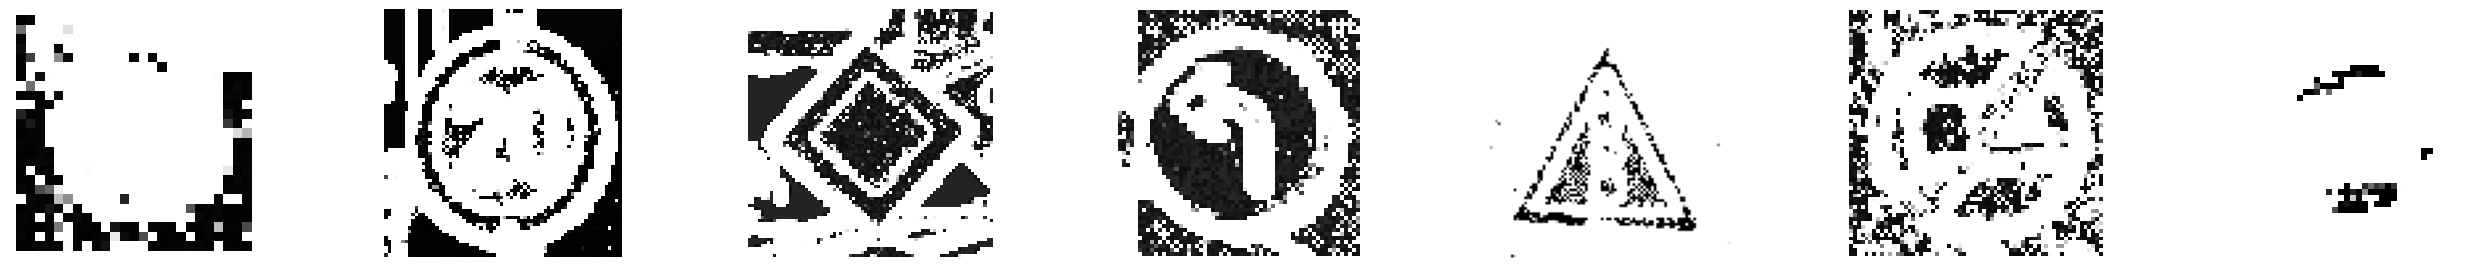

lambda: 1000


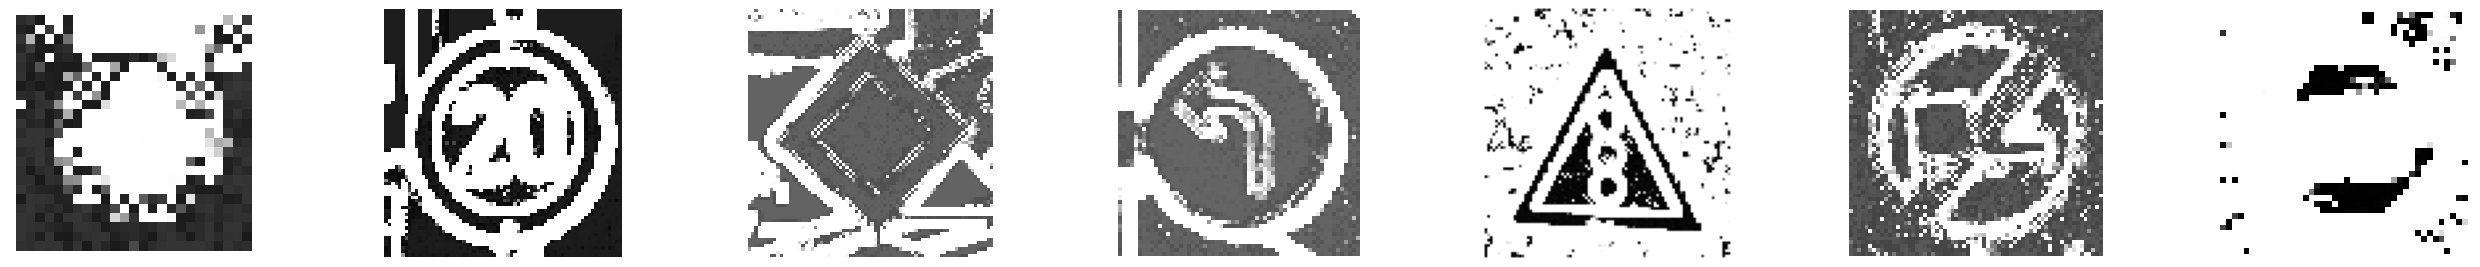

lambda: 0.10 percentile of trimmed mahalanobis distance


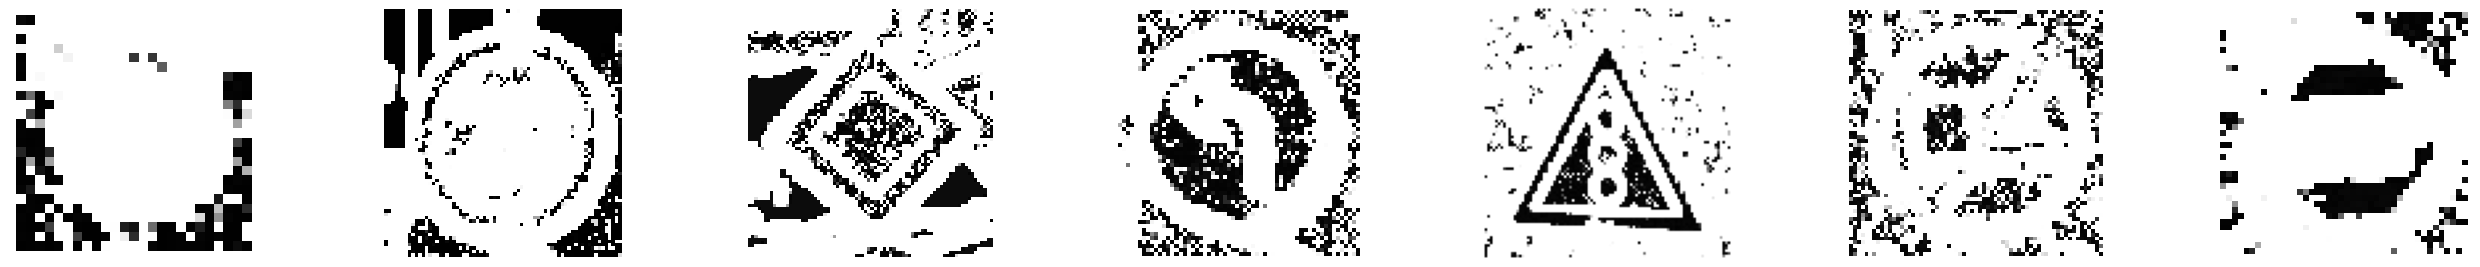

lambda: 0.25 percentile of trimmed mahalanobis distance


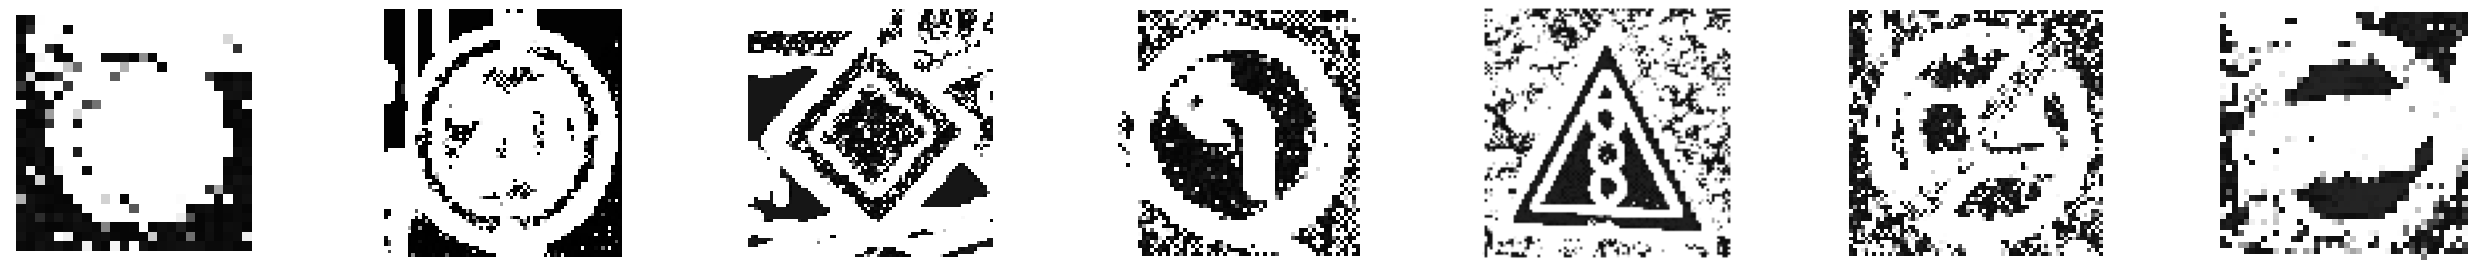

lambda: 0.50 percentile of trimmed mahalanobis distance


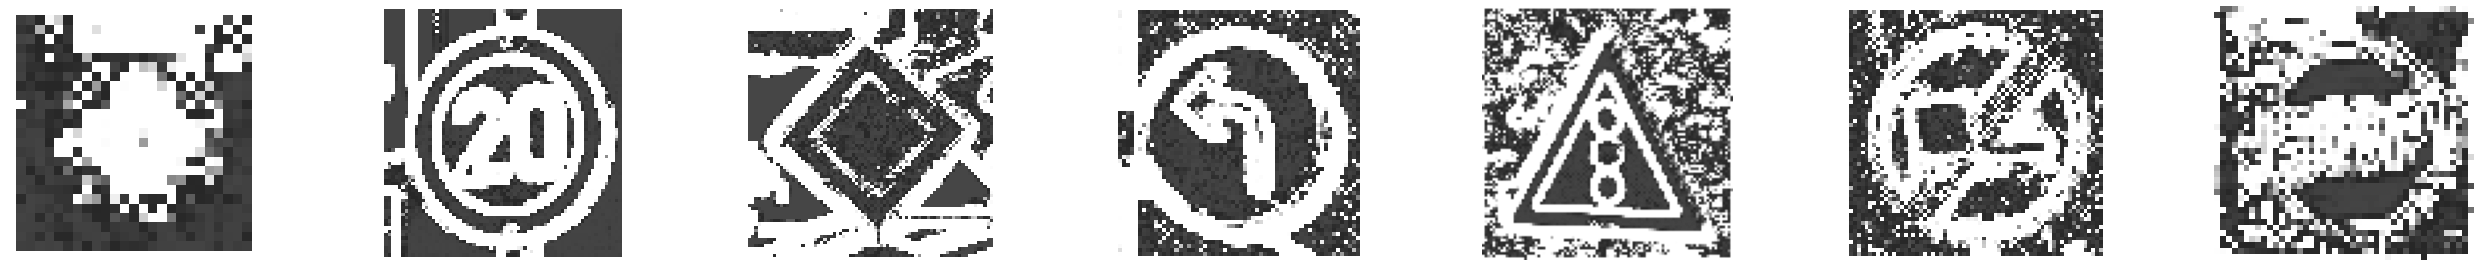

median


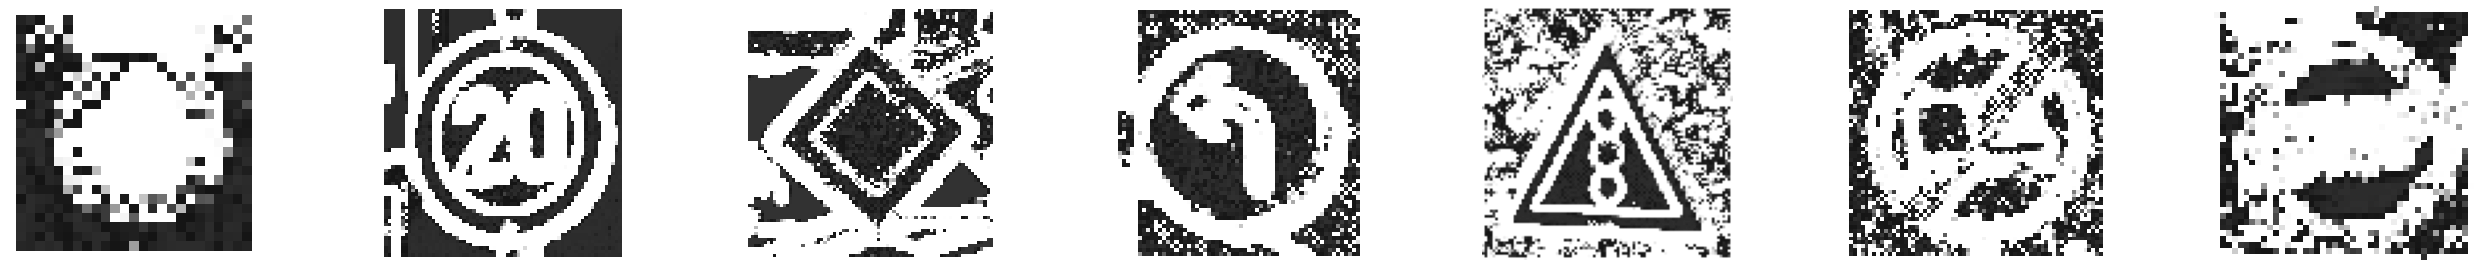

mixture of multiple confidences:


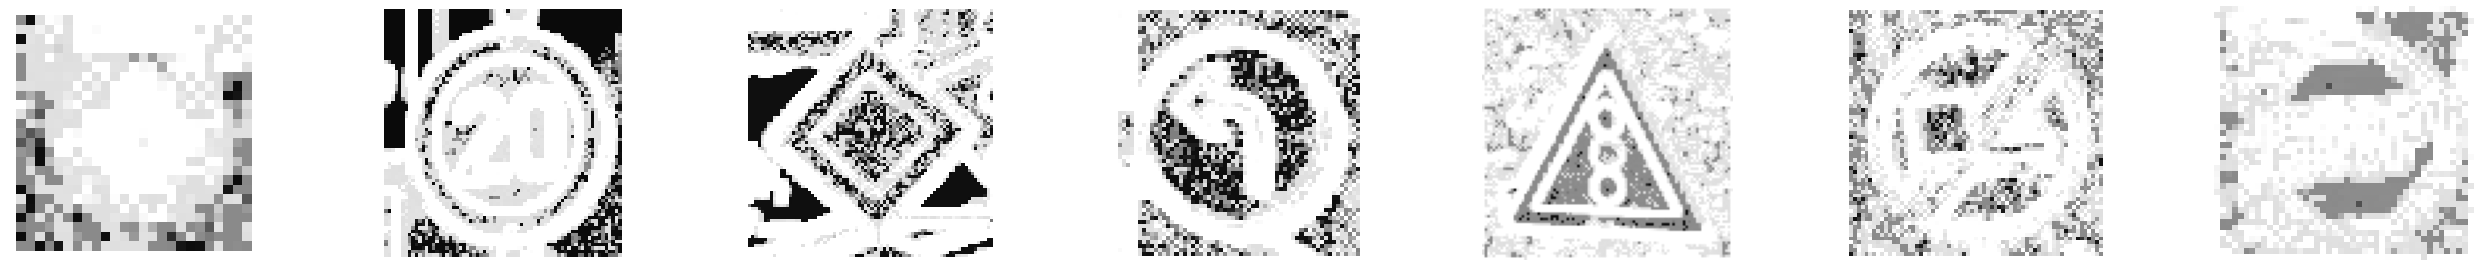

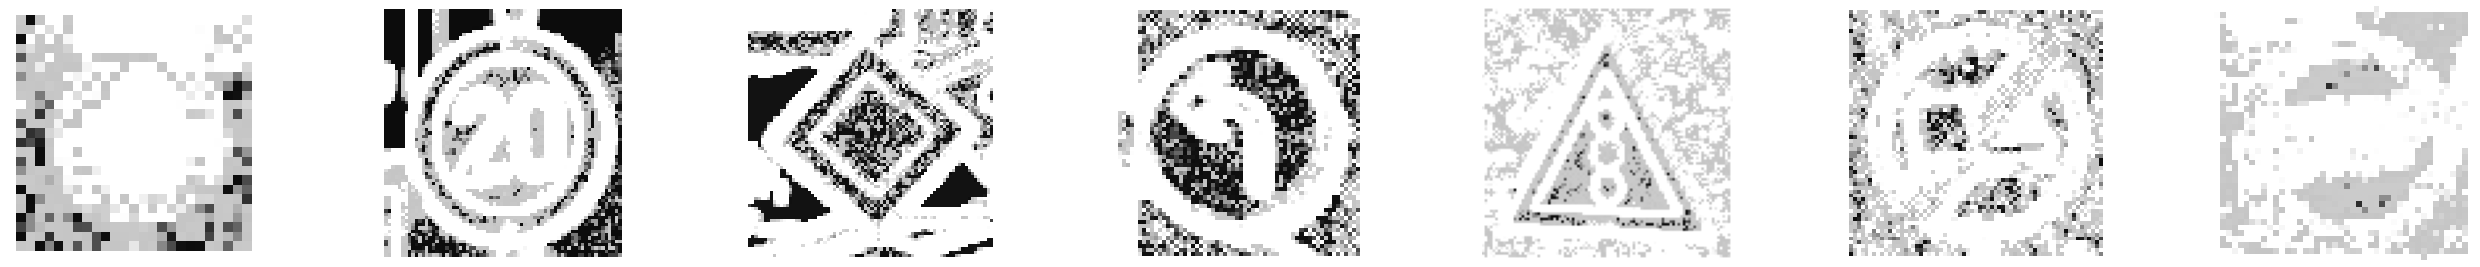

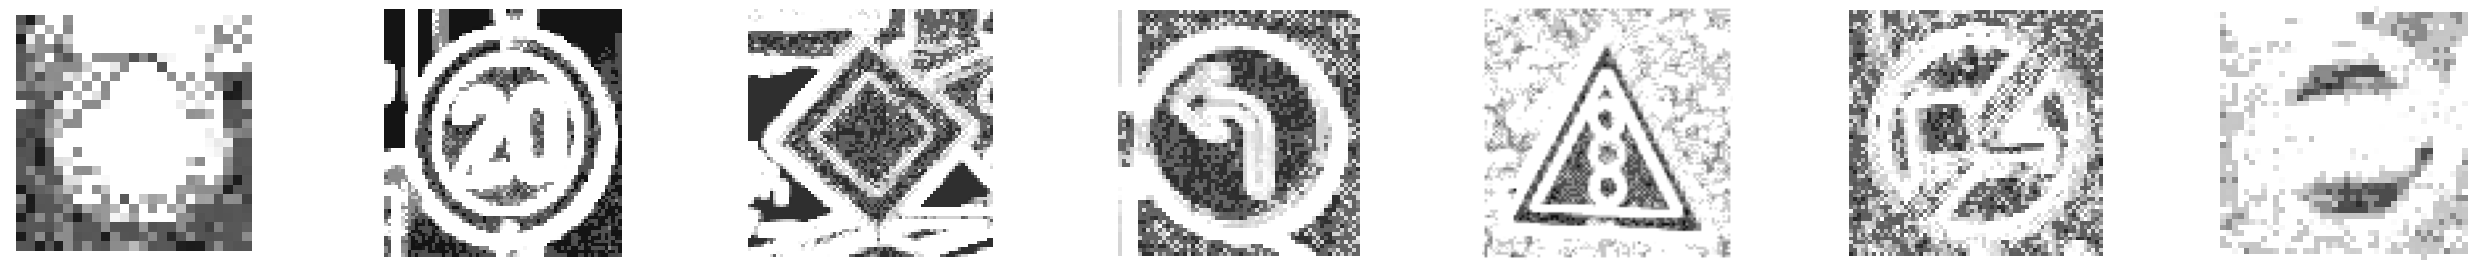

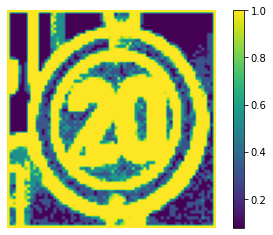

In [11]:
def conf(l,  diffs, mah_dist, trim_percentage = 5, p_H0= 0.5, p_H1 = 0.5):
    def moments_noncentral_chi(min_lambda,max_lambda, k):
        a = min_lambda
        b = max_lambda
        if b == 0:
            mu = 0
        else:
            mu = k+((a+b)/2)
        var = 2*k+2*(a+b)+1/12*(a*a+b*b+2*a*b)
        return mu, var
    
    conf = np.zeros((diffs.shape[0], diffs.shape[1]))
   
    # sort, trim 
    sorted_mah = np.sort(mah, axis = None)
    trimmed_mah = sorted_mah[int(len(sorted_mah)*0.05):-int(len(sorted_mah)*0.05)]
    
    min_lambdaH0 = 0
    max_lambdaH0 = min_lambdaH1 =l
    max_lambdaH1 = np.median(trimmed_mah)*1.75
    mu_d_H0, var_d_H0 = moments_noncentral_chi(min_lambdaH0,max_lambdaH0, diffs.shape[2])
    mu_d_H1, var_d_H1 = moments_noncentral_chi(min_lambdaH1,max_lambdaH1, diffs.shape[2])

    p_d_H0 = stats.norm.pdf(mah_dist, mu_d_H0, np.sqrt(var_d_H0))
    p_d_H1 = stats.norm.pdf(mah_dist, mu_d_H1, np.sqrt(var_d_H1))
    out = np.full(p_d_H1.shape,0.5)
    out[mah_dist>mu_d_H0]=1
    p = np.divide((p_d_H1* p_H1),(p_d_H1* p_H1+ p_d_H0*p_H0), out= out, where= (p_d_H1* p_H1+ p_d_H0*p_H0)>1e-9)
    return p

r, p = 1,8
confs=[]
percentiles = [0.1, 0.25,0.5]
lambdas = [0,1,10,100,1000]
for i,img in enumerate(images):
    confs.append([])
    sigma = estimateGaussianNoise(intensity_transform(img), Intensity()(img))
    d = diffs(r,p,intensity_transform(img))
    mah = mahalanobis_distance(d, noise_prop(p,sigma),p)
    sorted_mah = np.sort(mah, axis = None)
    trimmed_mah = sorted_mah[int(len(sorted_mah)*0.05):-int(len(sorted_mah)*0.05)]
    for l in lambdas: #fixed values
        confs[i].append(conf(l, d, mah))
    for perc in percentiles: # percentiles of trimmed values (for more robustness):
        confs[i].append(conf(trimmed_mah[int(perc*len(trimmed_mah))], d, mah))
    confs[i].append(conf(0.5*np.median(mah), d, mah))

for i in range(len(percentiles)+len(lambdas)+1):
    if i < len(lambdas):
        print("lambda:", lambdas[i])   
    elif i <len(lambdas)+len(percentiles):
        print("lambda: %.2f percentile of trimmed mahalanobis distance"%(percentiles[i-len(lambdas)]))
    else:
        print('median')
    plot_images([c[i] for c in confs])
    
print("mixture of multiple confidences:")
plot_images([0.5*c[0]+0.35*c[len(lambdas)]+0.15*c[len(lambdas)+2]  for c in confs])

plot_images([0.25*c[0]+0.25*c[1]+0.25*c[2]+0.25*c[len(lambdas)+len(percentiles)]  for c in confs])
plot_images([0.25*c[0]+0.25*c[3]+0.25*c[4]+0.25*c[len(lambdas)+len(percentiles)]  for c in confs])
plt.axis('off')
im = plt.imshow(0.25*confs[1][0]+0.25*confs[1][3]+0.25*confs[1][4]+0.25*confs[1][len(lambdas)+len(percentiles)])
plt.colorbar(im)
    
    

# PUT IT ALL TOGETHER (IN A CLASS):


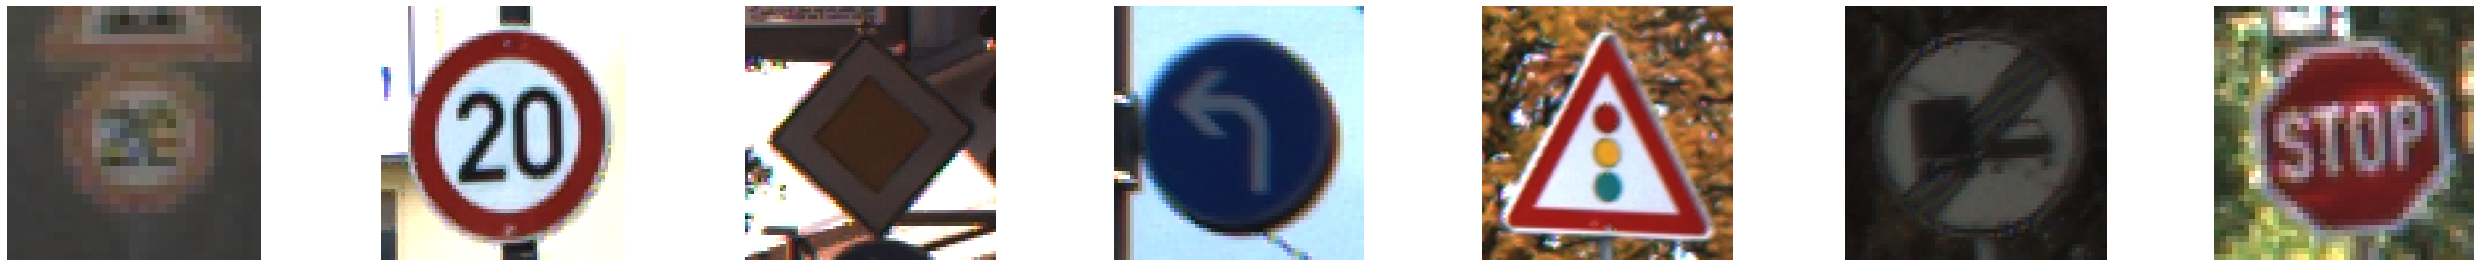

LBP(1,8):


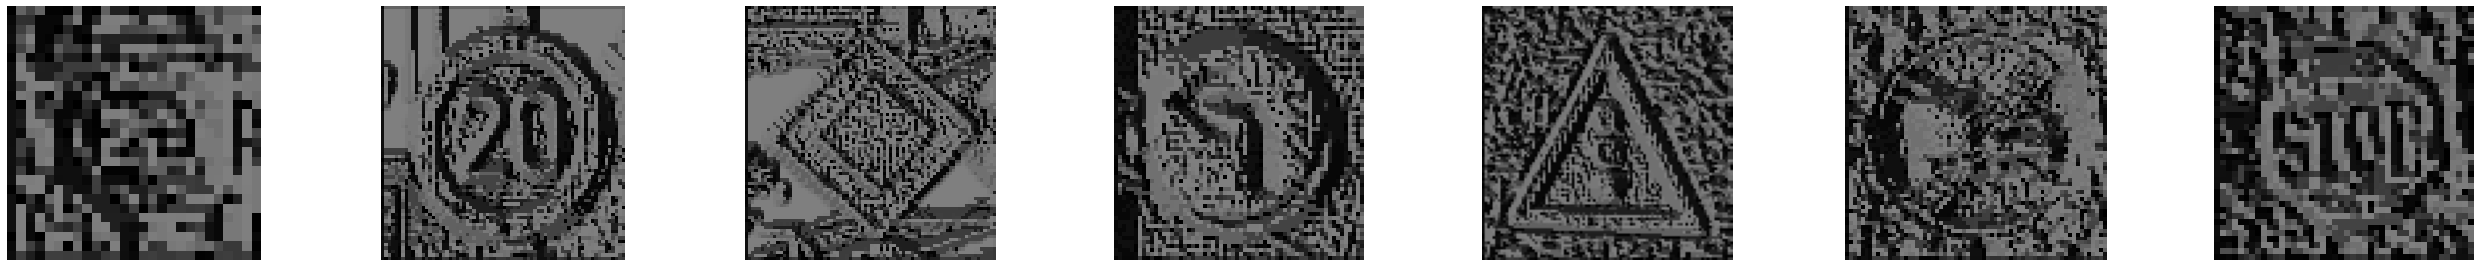

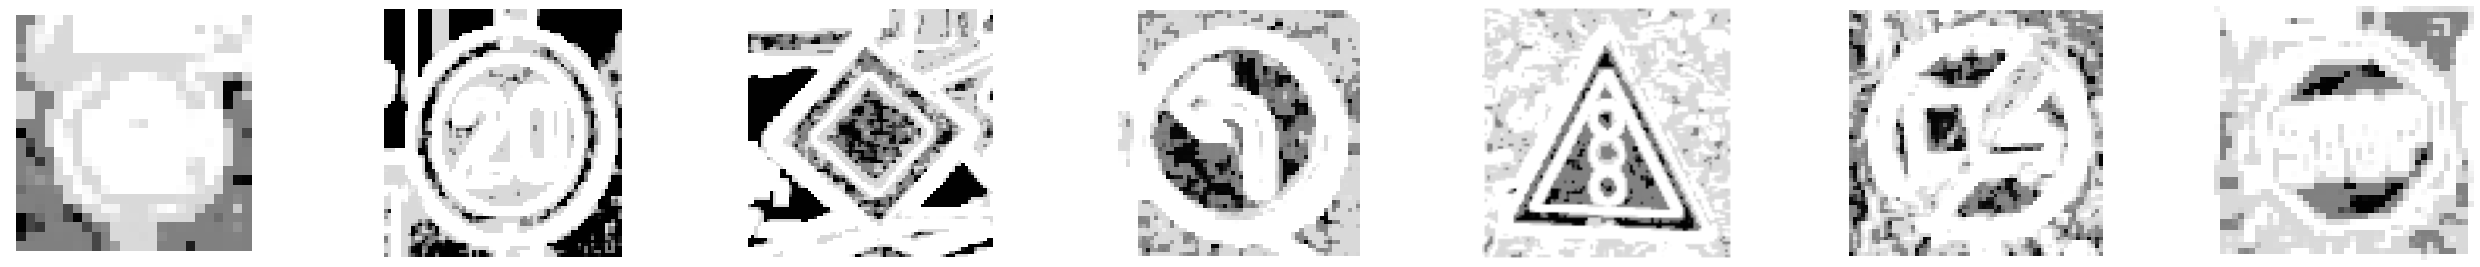

LBP(3,24):


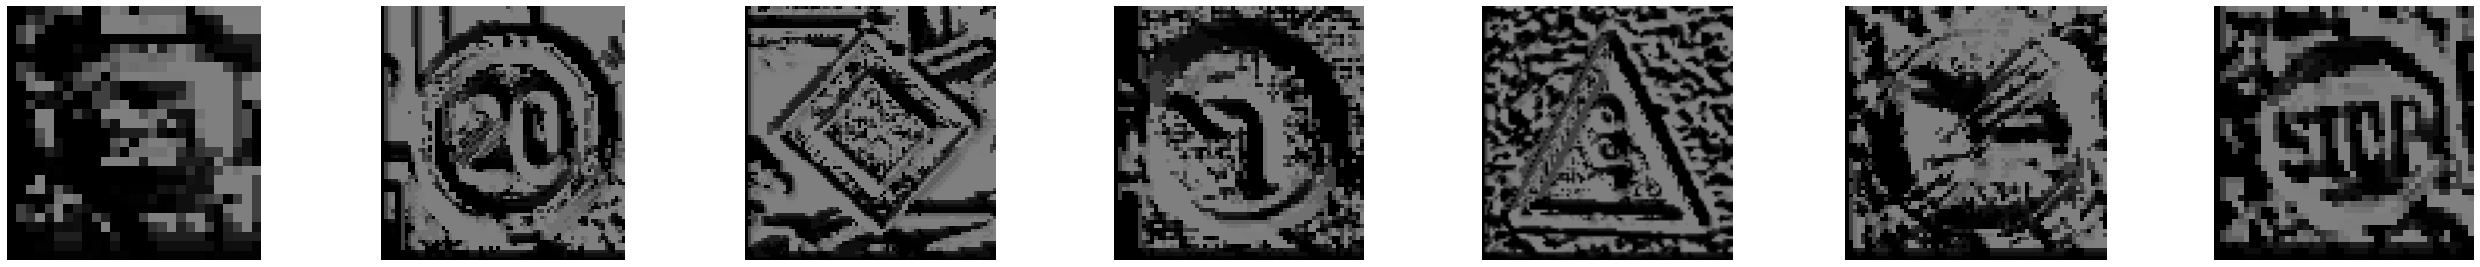

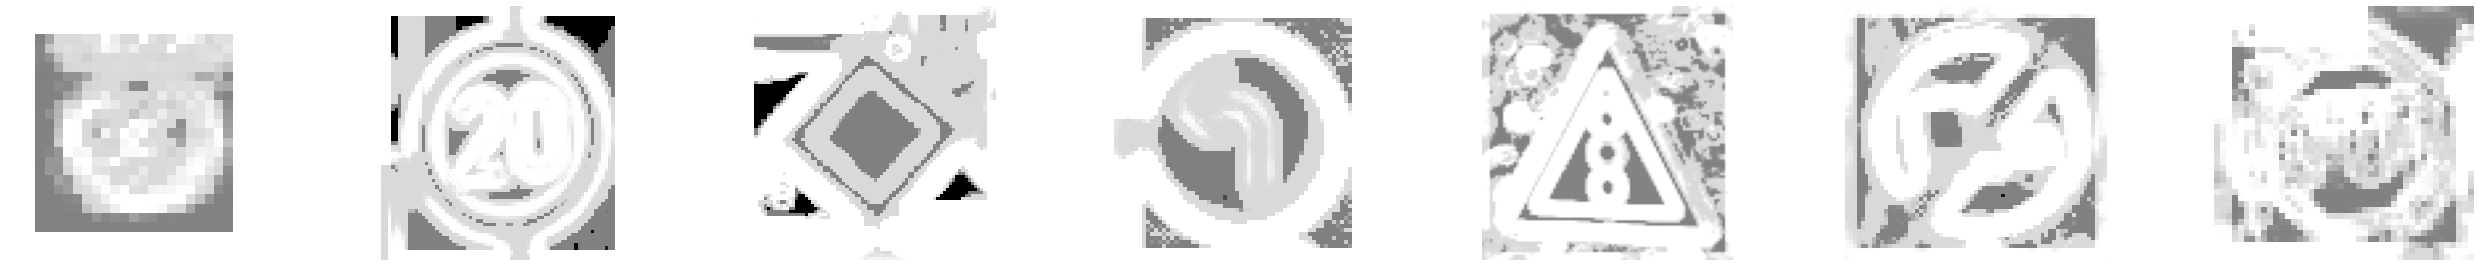

LBP(5,40):


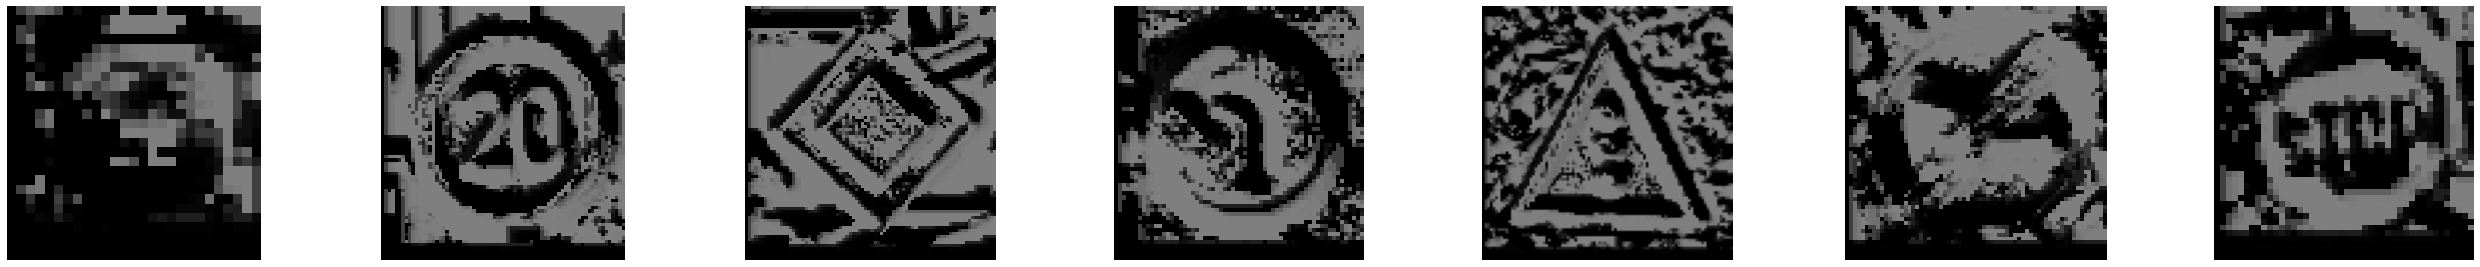

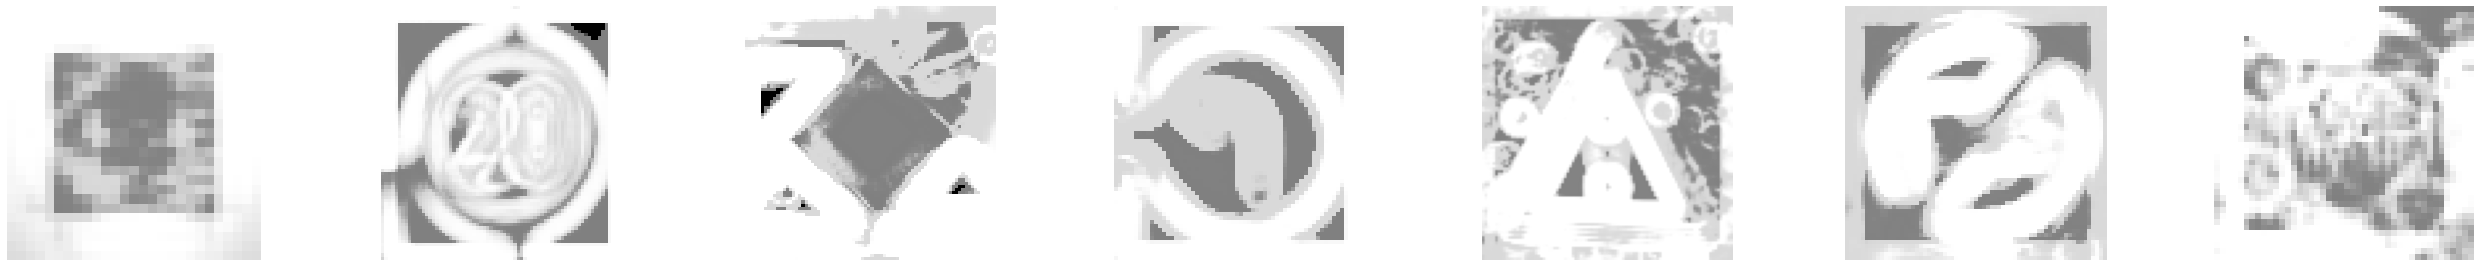

In [ ]:
from scipy import stats

class LBP(object):
    '''create p neighbouring positions in r distance to center pixel
       threshholding neighboring pixel with center pixel
       if neighbour >= center pixel => 1 else 0
       create decimal number from binary result'''
    def __init__(self, radius=1, points=8, conf = False):
        self.radius = radius
        self.points = points
        self.withConf = conf
        if self.withConf:
            self.noiseEstimator = estimateGaussianNoise

    def positions(self): #calculate neighbour positions
        a = 2*math.pi / self.points
        return [(int(round(self.radius *math.cos(a*i))),
                 int(round(self.radius *math.sin(a*i))))
                 for i in range(self.points)]

    def noise_prop(self, sigma):
        #Calculate covariance matrix S
        S = np.full((self.points,self.points), sigma**2) #self.points gives dimenion of binary number
        np.fill_diagonal(S,2*sigma**2)
        return S
    
    def get_inv_S(self,d,sigma):
        inv_S = np.full((d,d), -1/((d+1)*sigma**2)) #self.points gives dimenion of binary number
        np.fill_diagonal(inv_S, d/((d+1)*sigma**2))
        return inv_S
        
    def mahalanobis_distance(self, point,mean, inv_S):
        return np.matmul(np.matmul(np.transpose(point-mean),inv_S),(point-mean))

    def moments_noncentral_chi(self, min_lambda,max_lambda):
        a = min_lambda
        b = max_lambda
        if b == 0:
            mu = 0
        else:
            mu = 1/(b-a)*((2*b+(b*b)/2)- (2*a+(a*a)/2))
        var = 4+2*(a+b)-1/6*a*b+1/12*(a*a+b*b)
        return mu, var

    def posterior_H1_given_d(self, mah_dist, max_lambdaH0,min_lambda_H1, max_lambdaH1, p_H0=0.5, p_H1=0.5):
        min_lambdaH0 = 0

        mu_d_H0, var_d_H0 = self.moments_noncentral_chi(min_lambdaH0,max_lambdaH0)
        mu_d_H1, var_d_H1 = self.moments_noncentral_chi(min_lambda_H1,max_lambdaH1)

        p_d_H0 = stats.norm.pdf(mah_dist, mu_d_H0, np.sqrt(var_d_H0))
        p_d_H1 = stats.norm.pdf(mah_dist, mu_d_H1, np.sqrt(var_d_H1))
        out = np.full(p_d_H1.shape,0.5)
        out[mah_dist>mu_d_H0]=1
        p = np.divide((p_d_H1* p_H1),(p_d_H1* p_H1+ p_d_H0*p_H0), out= out, where= (p_d_H1* p_H1+ p_d_H0*p_H0)>1e-9)
        return p

    def conf(self, intensity, diffs, trim_percentage = 5):
        conf = np.zeros((diffs.shape[0], diffs.shape[1]))
        mah = np.zeros((diffs.shape[0], diffs.shape[1]))
        sigma = self.noiseEstimator(intensity, intensity)
        
        # calculate mah distance for each pixel
        inv_S = self.get_inv_S(self.points, sigma)
        for i in range(diffs.shape[0]): #TODO optimization possible?
            for j in range(diffs.shape[1]):
                mah[i,j] = self.mahalanobis_distance(diffs[i,j].reshape(self.points,1),np.zeros((self.points,1)),inv_S)
       
        # sort, trim 
        sorted_mah = np.sort(mah, axis = None)
        trimmed_mah = sorted_mah[int(len(sorted_mah)*0.05):-int(len(sorted_mah)*0.05)]
        
        # use multiple models(defined by lambda that seperates H0 and H1) and averge to cover uncertainties
        lambdas = [0,trimmed_mah[int(0.1*len(trimmed_mah))],np.median(trimmed_mah)]
        weights = [0.5,0.35,0.15]
        conf = np.expand_dims(self.posterior_H1_given_d(mah, lambdas[0], lambdas[0], np.median(mah)*1.75),axis=2)*weights[0]
        for l,w in zip(lambdas[1:],weights[1:]):
            tmp_conf =self.posterior_H1_given_d(mah, l, l, np.median(mah)*1.75)*w
            conf = np.concatenate([conf, np.expand_dims(tmp_conf, axis=2)], axis = 2) 
        conf = np.sum(conf, axis =2, keepdims = True)
        return conf 
        
    def __call__(self,data):
        # compare the the neighboring pixels to that of the central pixel
        neigbour = np.zeros((data.shape[0],data.shape[1],self.points))
        max_x, max_y = data.shape[1], data.shape[0]
        for i, (y,x) in enumerate(self.positions()):
            neigbour[max(0,-y):min(max_y, max_y-y), 
                     max(0,-x):min(max_x, max_x-x),
                     i] = data[max(0,y):min(max_y, max_y+y),
                               max(0,x):min(max_x, max_x+x)]
        diff = neigbour - np.repeat(data[:, :, np.newaxis], self.points, axis=2) #height,width, num_points
        
        # add conf based on the differences
        if self.withConf:
            c = self.conf(data, diff)
        
        # convert to binary: 0 if lessequall
        diff[diff >= 0] = 1
        diff[diff < 0] = 0
        
        # convert to decimal
        for i in range(self.points):
            diff[:,:,i]= diff[:,:,i]*2**i
        d = np.sum(diff,axis=2)
        out = d/float(2**(self.points+1)-1)#max decimal number, defined by number of points
        if self.withConf:
            out = np.concatenate([np.expand_dims(out, axis=2), c], axis = 2)
    
        return out

    def __str__(self):
        return "LBP(radius_%i_points_%i)"%(self.radius, self.points)
     
    
plot_images(images)
for (r,p) in [(1,8),(3,24),(5,40)]:
    print("LBP(%i,%i):"%(r,p))
    lbp = LBP(r,p, True)
    plot_images([lbp(Intensity()(img))[:,:,0] for img in images])
    plot_images([lbp(Intensity()(img))[:,:,1] for img in images])

